In [79]:
# Important reminders
# 1) Delete all old auto-generated txt files
#    a) These will be all the text files that end with "..._Table.txt" or "..._Uniform.txt"
#    b) When switching between TID and DD degradation, make sure to update the appropriate "my_... .txt" file with the appropriate degradation

In [80]:
%matplotlib inline

import os
import csv
import pandas as pd
from scipy.stats import norm
import numpy as np
from apply_ltspice_filter import apply_ltspice_filter
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from math import nan, isnan
import decimal

# https://acidbourbon.wordpress.com/2019/11/26/seamless-integration-of-ltspice-in-python-numpy-signal-processing/
# https://acidbourbon.wordpress.com/2019/12/04/ltspice-numpy-part-2-fast-convolution-filter

# https://www.electronicdesign.com/technologies/test-measurement/article/21807539/spice-simulates-custom-random-distributions-for-monte-carlo-analysis
# http://ecircuitcenter.com/Calc/MC_LTSPICE.html

In [81]:
# Generating Test Signals for Variety of Scenarios
 
# Alternating voltage is 1500 ms wide
# Steady voltage is 1500 ms wide
# Giving the signals a little space between start and end
sample_width_1 = 1200e-3
sample_width_2 = 1200e-3

# Time step between samples is 0.1 ms
delta_t_1 = 0.1e-3
delta_t_2 = 0.1e-3
samples_1 = int(sample_width_1/delta_t_1)
samples_2 = int(sample_width_2/delta_t_2)
 
time_1 = np.linspace(0,sample_width_1,samples_1)
time_2 = np.linspace(0,sample_width_2,samples_2)
 
# Increasing Signal from 25 V to 45 V to Check Whether Linear Voltage Regulator Works as Intended
# 25 V, 30 V, 35 V, 40 V, 45 V every other 100 ms
# Total Signal lasts 1200 ms
signal_a1 = 0+25*((time_1 > 100e-3)*(time_1 < 200e-3)) + 30*((time_1 > 300e-3)*(time_1 < 400e-3)) + 35*((time_1 > 500e-3)*(time_1 < 600e-3)) + 40*((time_1 > 700e-3)*(time_1 < 800e-3)) + 45*((time_1 > 900e-3)*(time_1 < 1000e-3))

# Increasing Signal from 25 V to 45 V to Test Degradation Factors
# 25 V, 30 V, 35 V, 40 V, 45 V every other 100 ms
# Total Signal lasts 1200 ms
signal_a2 = 0+25*((time_1 > 100e-3)*(time_1 < 200e-3)) + 30*((time_1 > 300e-3)*(time_1 < 400e-3)) + 35*((time_1 > 500e-3)*(time_1 < 600e-3)) + 40*((time_1 > 700e-3)*(time_1 < 800e-3)) + 45*((time_1 > 900e-3)*(time_1 < 1000e-3))

In [82]:
# PDF Equation

def normal_dist(x , mean , sd):
    prob_density = ((sd*((2*np.pi)**(0.5)))**-1) * np.exp(-0.5000*((x-mean)/sd)**2)
#     print(prob_density)
    return prob_density

# Creating a Lookup Table Function

def lookup_generator(mean, sd, minimum, maximum, device, degradationParam, radType):
    # Creating the x values
    xValues = np.linspace(minimum, maximum, 100, endpoint=True).tolist()

    # Calculating PDF
    pdfList = []
    for i in xValues:
        pdfList.append(normal_dist(i,mean,sd))

    # print(pdfList)
    pdfSummed = np.sum(pdfList)
    # print(pdfSummed)

    # Calculating CDF
    cdfList = []
    for i in range(len(xValues)):
        if not cdfList:
            cdfList.append(pdfList[i])
        else:
            cdfList.append((pdfList[i]+cdfList[i-1]))
    cdfList = cdfList/pdfSummed

    mcmcData= {
        'Data': pdfList, 
        'CDF': cdfList,
        'x': xValues
    }
    mcmcTable = pd.DataFrame(data=mcmcData)
#     plt.plot(mcmcTable["CDF"], mcmcTable["x"], label="LTspice's Random Number Generator (Input)")
#     plt.xlabel("CDF")
#     plt.xlim([0,1])
#     plt.ylabel(device+"'s "+degradationParam)
# #     plt.ylim([1,6])
#     plt.legend()
#     plt.title("Inverse Cumulative Density Function (ICDF) \n"+radType)
#     plt.grid(True)
    
    return(mcmcTable)

In [83]:
# Gaussian

# mcmcTable.plot(x="x", y="GDF at TID of 100krad")
# plt.title("Gaussian Distribution")
# plt.xlabel("Gain Degradation Factor (GDF)")
# plt.ylabel("Probability Distribution Function (PDF)")

In [84]:
# CDF (Cumulative Density Function)

# mcmcTable.plot(x="x", y="CDF")
# plt.title("CDF vs. x")
# plt.xlabel("Gain Degradation Factor (GDF)")
# plt.ylabel("Cumulative Distribution Function (CDF)")

In [85]:
# ICDF (Inverse CDF)

# mcmcTable.plot(x="CDF", y="x")
# plt.title("ICDF - x vs. CDF")
# plt.xlabel("Cumulative Distribution Function (CDF)")
# plt.ylabel("x")

In [100]:
# Degradation Parameters for all Components 
# Taken from Bayesian analysis

# BJT
BJT_TID = lookup_generator(2.39923, 0.474827, 1.82990467, 2.86903288065, "BJT", "GDF", "TID")
BJT_DD = lookup_generator(16.38037, 0.3803707, -2.9646, 45.981202, "BJT", "RDF", "DD")

# OpAmp (non-rad)
# opamp_TID = lookup_generator(0.7803, 0.110959, -3.83928, 9.82896, "OpAmp", "ADF", "TID")
# opamp_DD = lookup_generator(-155.628, 0.6284863, -182.566589, -125.094, "OpAmp", "IDF", "DD")

# OpAmp (rad)
opamp_TID = lookup_generator(0.7803, 0.110959, -3.83928, 9.82896, "OpAmp", "ADF", "TID")
opamp_DD = lookup_generator(-41.799576, 0.799576, -117.208, 17.720538, "OpAmp", "IDF", "DD")

# Voltage Reference
VoltRef_TID = lookup_generator(0.999, 0.0012, 0.7879932, 1.557797, "VoltRef", "VDF", "TID")
VoltRef_DD = lookup_generator(1.0025, 0.0014, 0.99842679, 1.008923, "VoltRef", "RDF", "DD")

In [101]:
# Constructing LTspice Lookup Table for all parts in the Linear Voltage Regulator
# LTspice table function defined as table(input, x0,y0,x1,y1,...)

def textFile_lookup(partType, mcmcTable, degradationParam, distributionType):
    # LTspice table function defined as table(input, x0,y0,x1,y1,...)

    lookupList=[]

    for x,y in zip(mcmcTable["CDF"], mcmcTable["x"]):
        lookupList.append(str(x))
        lookupList.append(str(y))

    spiceTable = str("Table(uniform(), ")+(", ".join(lookupList))+str(")")
    # print(spiceTable)

    gdf_spiceCommand = str(".function "+degradationParam+"_"+partType+"_"+distributionType+"() "+spiceTable)
    # print(gdf_spiceCommand)

    placeholder = str(".function "+degradationParam+"_"+partType+"_"+distributionType+"() 1")
    
    return(partType, placeholder, gdf_spiceCommand)

In [102]:
# BJT
bjt_tid_file = textFile_lookup("BJT", BJT_TID, "GDF", "Gaussian")
bjt_dd_file = textFile_lookup("BJT", BJT_DD, "CDF", "Gaussian")

# OpAmp
opamp_tid_file = textFile_lookup("OpAmp", opamp_TID, "ADF", "Gaussian")
opamp_dd_file = textFile_lookup("OpAmp", opamp_DD, "IDF", "Gaussian")

# Voltage Reference
voltref_tid_file = textFile_lookup("VoltRef", VoltRef_TID, "ODF_TID", "Gaussian")
voltref_dd_file = textFile_lookup("VoltRef", VoltRef_DD, "ODF_DD", "Gaussian")

In [103]:
# Text File Writer - placeholder

# Create a .txt file for the MCMC

def textfile_writer_placeholder(fileName, placeholder,radType):
    with open(fileName+"_"+radType+'_Table.txt', 'w') as f:
        f.write(placeholder)

In [104]:
# Text File Writer - spice command
# Create a .txt file for the MCMC

def textfile_writer_mcmc(fileName, gdf_spiceCommand,radType):
    with open(fileName+"_"+radType+'_Table.txt', 'w') as f:
        f.write('\n')
        f.write(gdf_spiceCommand)

In [105]:
# Text File Writer - uniform command
# Create a .txt file for the MCMC

def textfile_writer_uniform():
    with open('function_Uniform.txt', 'w') as f:
        f.write('\n')
        uniform_spiceCommand = str(".function uniform() flat(0.5)+0.5")
        f.write(uniform_spiceCommand)

In [106]:
# List of Parts

list_of_parts_tid = [
    # BJT
    bjt_tid_file,

    # OpAmp
    opamp_tid_file,

    # VoltRef
    voltref_tid_file
]

list_of_parts_dd = [
    # BJT
    bjt_dd_file,

    # OpAmp
    opamp_dd_file,

    # VoltRef
    voltref_dd_file
]

In [107]:
# TID or DDD Determiner

def tid_or_dd(placeholder, TID):
    if placeholder == "True":
        for i in list_of_parts_dd:
            textfile_writer_placeholder(i[0], i[1], "DD")
        for i in list_of_parts_tid:
            textfile_writer_placeholder(i[0], i[1], "TID")
    if placeholder == "False":
        if TID == "True":
            for i in list_of_parts_dd:
                textfile_writer_mcmc(i[0], i[1], "DD")            
            for i in list_of_parts_tid:
                textfile_writer_mcmc(i[0], i[2], "TID")
        else:
            for i in list_of_parts_tid:
                textfile_writer_mcmc(i[0], i[1], "TID")
            for i in list_of_parts_dd:
                textfile_writer_mcmc(i[0], i[2], "DD") 

In [109]:
# Config. 1 (Expected Parameters for all Components)
# All values are in SI units.

# Make sure the option 'Automatically delete .raw and .log files' is turned off in LTspice. To do so: 1) go into an empty project in LTspice; 2) Click the 'Hammer' icon; 3) Go to 'Operation'; and 4) Unclick 'Automatically delete .raw and .log files.'

# Go into LTspice and manually make a SPICE Netlist: 1) Click workscreen and click 'View' and then 'SPICE Netlist'; 2) Manually save the resultant .net file; 3) Click 'Run' for the resultant .net file.

# 'vout' in LTspice model is loc of output voltage

# Create a .txt file for the MCMC

# Placeholder
tid_or_dd("True", "False")
           
textfile_writer_uniform()

# Configuration 1 (all values in SI units)
# Must run LTspice model right after running the 'apply_ltspice_filter()' Python code in order for this to work properly.

configuration_1 = {
    # BJT
    "bjt_degrade": 1, # BJT's GDF
    # Op Amp
    "opamp_degrade": 1e5, # Op-Amp's ADF
    # Voltage Reference
    "voltref_degrade": 1.25, # Shunt Voltage Reference's VDF
}

dummy, signal_b1 = apply_ltspice_filter(
    "LinVoltReg_v6.asc",
    time_1, 
    signal_a1, # Varying voltage to test functionality
    params=configuration_1
)

sig_in.csv has not changed
trancmd.txt has not changed
param.txt has not changed
LinVoltReg_v6.asc is older than LinVoltReg_v6.raw
input data did not change, reading existing .raw file
Normal access


In [111]:
# Config. 2 (All Linear Voltage Regulator Components)

# Create a .txt file for the MCMC

# TID
# tid_or_dd("False", "True")
# textfile_writer_uniform()

# DD
tid_or_dd("False", "False")
textfile_writer_uniform()

configuration_2 = { 
    # BJT
    "bjt_degrade": 1, # BJT's GDF
    # Incorporating BJT's Gain Degradation Factor (2.5). Setting GDF to be 1 here because we apply the real GDF value in the GDF_Gaussian() function.
    # Op Amp
    "opamp_degrade": 1e5, # Op-Amp's ADF (is NaN for some reason, so removing from LTspice)
    # Voltage Reference
    "voltref_degrade": 1.25, # Shunt Voltage Reference's VDF
}

# TID
# dummy, signal_b2 = apply_ltspice_filter(
#     "LinVoltReg_v6.asc",
#     time_2,
#     signal_a2, # Steady voltage to test degradation effect on linear voltage regulator output
#     params=configuration_2
# )

#DD_nonRad
# dummy, signal_b3 = apply_ltspice_filter(
#     "LinVoltReg_v6.asc",
#     time_2,
#     signal_a2, # Steady voltage to test degradation effect on linear voltage regulator output
#     params=configuration_2
# )

#DD_Rad
dummy, signal_b4 = apply_ltspice_filter(
    "LinVoltReg_v6.asc",
    time_2,
    signal_a2, # Steady voltage to test degradation effect on linear voltage regulator output
    params=configuration_2
)

#os.remove("TablesCDF.txt")

sig_in.csv has not changed
trancmd.txt has not changed
param.txt has not changed
LinVoltReg_v6.asc is older than LinVoltReg_v6.raw
input data did not change, reading existing .raw file
Normal access


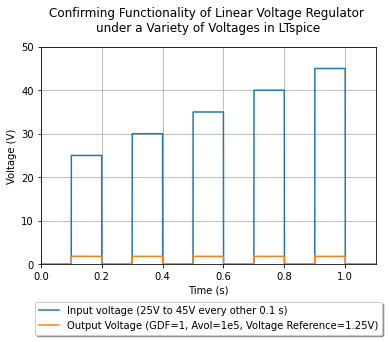

In [112]:
# Plotting Input vs. Output of Config. 1

plt.plot(time_1,signal_a1, label="Input voltage (25V to 45V every other 0.1 s)")
plt.plot(time_1,signal_b1, label="Output Voltage (GDF=1, Avol=1e5, Voltage Reference=1.25V)")

plt.title("Confirming Functionality of Linear Voltage Regulator \nunder a Variety of Voltages in LTspice", pad=15)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.xlim((0,1.1))
plt.ylim((0,50))
# plt.yscale('log')
plt.grid(True)

plt.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True,
    shadow=True, 
    ncol=1
)
plt.show()

In [113]:
# # Scatter Plot of Input vs. Output for Config. 1

# plt.plot(signal_a1,signal_b1, '.', color='blue')

# plt.title("Confirming Functionality of BJT under a Variety of Voltages in LTspice", pad=15)
# plt.xlabel("Input voltage (10V to 30V every other 0.1 s)")
# plt.ylabel("Output Voltage\n(GDF=1, Avol=1e5, Voltage Reference=1.25V)")
# #plt.ylim((0,35))
# plt.xlim((9,31))
# plt.grid(True)

# # plt.legend(
# #     loc='upper center', 
# #     bbox_to_anchor=(0.5, -0.15),
# #     fancybox=True,
# #     shadow=True, 
# #     ncol=1
# # )
# plt.show()

In [114]:
# # Scatter Plot of Input vs. Output for Config. 3

# plt.plot(signal_a3, signal_b3, '.', color='blue')

# plt.title("Observing Output Due to BJT Degradation", pad=15)
# plt.xlabel("Input voltage (10V to 30V every other 0.1 s)")
# plt.ylabel("Output Voltage\n(GDF=2.5, Avol=1e5, Voltage Reference=1.25V)")
# #plt.ylim((0,35))
# plt.xlim((9,31))
# plt.grid(True)

# # plt.legend(
# #     loc='upper center', 
# #     bbox_to_anchor=(0.5, -0.15),
# #     fancybox=True,
# #     shadow=True, 
# #     ncol=1
# # )
# plt.show()

In [115]:
# # Plotting Input vs. Output of Config. 2

# plt.plot(time_2,signal_a2, label="Input voltage (5V)")
# plt.plot(time_2,signal_b2, label="Output Voltage (GDF=2.5, Avol=1e6, Voltage Reference=1.25V)")

# plt.title("Simulating BJT's GDF in LTspice", pad=15)
# plt.xlabel("Time (s)")
# plt.xlim((0.28,0.42))
# plt.ylabel("Voltage (V)")
# plt.ylim((0,5.5))
# plt.grid(True)

# plt.legend(
#     loc='upper center', 
#     bbox_to_anchor=(0.5, -0.15),
#     fancybox=True,
#     shadow=True,
#     ncol=1
# )
# plt.show()

In [116]:
# # Scatter Plot of Input vs. Output of Config. 2

# plt.hist(signal_b2, bins = 100, color='blue')

# plt.title("Input voltage (5V)", pad=15)
# plt.xlabel("Output Voltage\n(GDF=2.5, Avol=1e5, Voltage Reference=1.25V)")
# plt.ylabel("Counts")

# plt.xlim((0.01, 0.6))
# plt.ylim((0, 25))

# plt.grid(True)
# plt.show()

In [117]:
# Cleaning up the Non-Degraded Output Data and Degraded Output Data

nondegradedOutput = signal_b1[~np.isnan(signal_b1)]
nondegradedOutput = np.where(nondegradedOutput > 0.01, nondegradedOutput, 0)
nondegradedOutput = nondegradedOutput[nondegradedOutput != 0]

# TID
degradedOutput1 = signal_b2[~np.isnan(signal_b2)]
degradedOutput1 = np.where(degradedOutput1 > 0.01, degradedOutput1, 0)
degradedOutput1 = degradedOutput1[degradedOutput1 != 0]

# DD (with non-rad op amp)
degradedOutput2 = signal_b3[~np.isnan(signal_b3)]
degradedOutput2 = np.where(degradedOutput2 > 0.01, degradedOutput2, 0)
degradedOutput2 = degradedOutput2[degradedOutput2 != 0]

# DD (with rad op amp)
degradedOutput3 = signal_b4[~np.isnan(signal_b4)]
degradedOutput3 = np.where(degradedOutput3 > 0.01, degradedOutput3, 0)
degradedOutput3 = degradedOutput3[degradedOutput3 != 0]

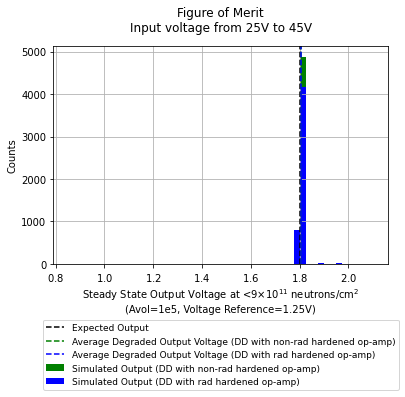

In [118]:
# Scatter Plot of Input vs. Output of Config. 3

plt.axvline(x=1.8, linestyle='--', color='black', label="Expected Output")

# plt.hist(degradedOutput1, bins = 50, color='red', label='Simulated Output (TID)')
# plt.axvline(x=np.mean(degradedOutput1), linestyle='--', color='red', label="Average Degraded Output Voltage (TID)")
# plt.xlabel("Steady State Output Voltage at <100 krad($SiO_{2}$)\n(Avol=1e5, Voltage Reference=1.25V)")
# plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol= 1, prop={'size': 9})

plt.hist(degradedOutput2, bins = 50, color='green', label='Simulated Output (DD with non-rad hardened op-amp)')
plt.axvline(x=np.mean(degradedOutput2), linestyle='--', color='green', label="Average Degraded Output Voltage (DD with non-rad hardened op-amp)")

plt.hist(degradedOutput3, bins = 50, color='blue', label='Simulated Output (DD with rad hardened op-amp)')
plt.axvline(x=np.mean(degradedOutput3), linestyle='--', color='blue', label="Average Degraded Output Voltage (DD with rad hardened op-amp)")

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
plt.xlabel("Steady State Output Voltage at <$9×10^{11}$ neutrons/cm$^2$\n(Avol=1e5, Voltage Reference=1.25V)")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol= 1, prop={'size': 9})

plt.title("Figure of Merit\nInput voltage from 25V to 45V", pad=15)
plt.ylabel("Counts")

# plt.xlim((0, 2.0))
# plt.ylim((0, 1000))

plt.grid(True)

plt.show()

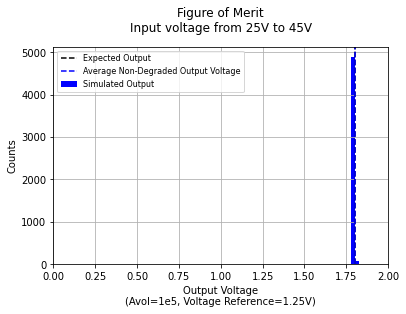

In [119]:
# Scatter Plot
# Returning to Config. 1 in order to Focusing on Region Seen in Config. 2

plt.hist(nondegradedOutput, bins = 50, color='blue', label='Simulated Output')
plt.axvline(x=1.8, linestyle='--', color='black', label='Expected Output')
plt.axvline(x=np.mean(nondegradedOutput), linestyle='--', color='blue', label="Average Non-Degraded Output Voltage")

plt.title("Figure of Merit\nInput voltage from 25V to 45V", pad=15)
plt.xlabel("Output Voltage\n(Avol=1e5, Voltage Reference=1.25V)")
plt.ylabel("Counts")
plt.xlim((0, 2.0))
# plt.ylim((0, 100))
plt.grid(True)
plt.legend(prop={'size': 8})
            
plt.show()

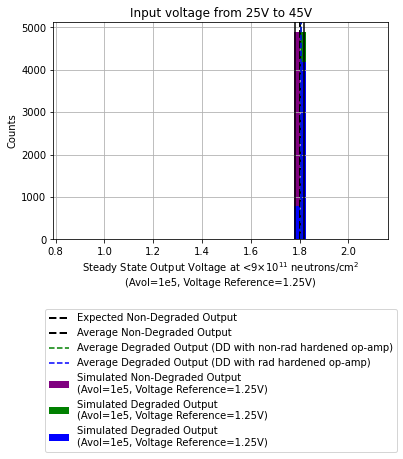

In [120]:
# Scatter Plot of Input vs. Output of Config. 2 and 3

# Scatter Plot of Input vs. Output of Config. 3

plt.axvline(x=1.8, linestyle='--', color='black', linewidth=2, label="Expected Non-Degraded Output")
plt.axvline(x=np.mean(nondegradedOutput), linestyle='--', linewidth=2, color='black', label="Average Non-Degraded Output")
plt.hist(nondegradedOutput, bins = 50, color='purple', label='Simulated Non-Degraded Output\n(Avol=1e5, Voltage Reference=1.25V)')

# TID

# plt.hist(degradedOutput1, bins = 50, color='red', label='Simulated Degraded Output\n(Avol=1e5, Voltage Reference=1.25V)')
# plt.axvline(x=np.mean(degradedOutput1), linestyle='--', color='red', label="Average Degraded Output (TID)")
# plt.xlabel("Steady State Output Voltage at <100 krad($SiO_{2}$)")

# plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.7), ncol= 1)

# DD

plt.hist(degradedOutput2, bins = 50, color='green', label='Simulated Degraded Output\n(Avol=1e5, Voltage Reference=1.25V)')
plt.axvline(x=np.mean(degradedOutput2), linestyle='--', color='green', label="Average Degraded Output (DD with non-rad hardened op-amp)")

plt.hist(degradedOutput3, bins = 50, color='blue', label='Simulated Degraded Output\n(Avol=1e5, Voltage Reference=1.25V)')
plt.axvline(x=np.mean(degradedOutput3), linestyle='--', color='blue', label="Average Degraded Output (DD with rad hardened op-amp)")
plt.xlabel("Steady State Output Voltage at <$9×10^{11}$ neutrons/cm$^2$\n(Avol=1e5, Voltage Reference=1.25V)")

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -1), ncol= 1)

# Showing the 1% Range
plt.axvline(x=1.8*1.01, linestyle='-', color='black', label="Average Degraded Output")
plt.axvline(x=1.8*0.99, linestyle='-', color='black', label="Average Degraded Output")

plt.title("Input voltage from 25V to 45V", pad=5)
plt.ylabel("Counts")
# plt.xlim((0.25, 2.0))
# plt.ylim((0, 500))

plt.grid(True)

plt.show()

In [121]:
# # Returning to Config. 1 in order to Focusing on Region Seen in Config. 2

# plt.plot(time_1, signal_a1, label="Input voltage (0V to 30V every other 0.01 s)")
# plt.plot(time_1, signal_b1, label="Output Voltage (GDF=1, Avol=1e5, Voltage Reference=1.25V)")

# plt.title("Focusing on 5 V Region in BJT without Degraded BJT", pad=15)
# plt.xlabel("Time (s)")
# plt.xlim((0.28,0.42))
# plt.ylabel("Voltage (V)")
# plt.ylim((0,5.5))
# plt.grid(True)

# plt.legend(
#     loc='upper center', 
#     bbox_to_anchor=(0.5, -0.15),
#     fancybox=True,
#     shadow=True, 
#     ncol=1
# )
# plt.show()

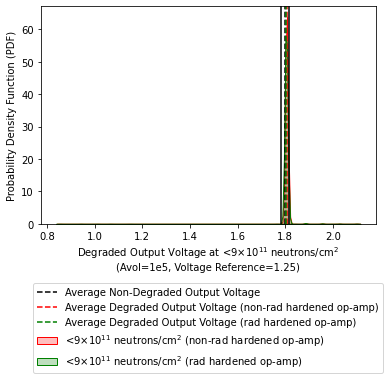

In [122]:
# Creating a KDE plot using the Degraded Output Voltage Data

# TID

# sns.kdeplot(
#     degradedOutput1,
#     label='<100 krad($SiO_{2}$)',
#     color='black',
#     fill='True'
# )
# plt.axvline(1.8, linestyle='--', color='black', label="Calculated Output Voltage")
# plt.axvline(x=np.mean(nondegradedOutput), linestyle='--', color='black', label="Average Non-Degraded Output Voltage")
# plt.axvline(x=np.mean(degradedOutput1), linestyle='--', color='red', label="Average Degraded Output Voltage")
# plt.xlabel('Degraded Output Voltage at <100 krad($SiO_{2}$)')
# plt.legend(fontsize=10, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1)

# DD

sns.kdeplot(
    degradedOutput2,
    label='<$9×10^{11}$ neutrons/cm$^2$ (non-rad hardened op-amp)',    
    color='red',
    fill='True'
)
sns.kdeplot(
    degradedOutput3,
    label='<$9×10^{11}$ neutrons/cm$^2$ (rad hardened op-amp)',    
    color='green',
    fill='True'
)

plt.axvline(x=np.mean(nondegradedOutput), linestyle='--', color='black', label="Average Non-Degraded Output Voltage")
plt.axvline(x=np.mean(degradedOutput2), linestyle='--', color='red', label="Average Degraded Output Voltage (non-rad hardened op-amp)")
plt.axvline(x=np.mean(degradedOutput3), linestyle='--', color='green', label="Average Degraded Output Voltage (rad hardened op-amp)")
plt.legend(fontsize=10, loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=1)
plt.xlabel("Degraded Output Voltage at <$9×10^{11}$ neutrons/cm$^2$\n(Avol=1e5, Voltage Reference=1.25)")

plt.ylabel('Probability Density Function (PDF)')
# plt.ylim([0, 3])
# plt.yticks(np.linspace(0, 1, 11), fontsize=13)
# plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
# plt.tick_params(axis="y",direction="in", pad=10)

# Showing the 1% Range
plt.axvline(x=1.8*1.01, linestyle='-', color='black', label="Average Degraded Output")
plt.axvline(x=1.8*0.99, linestyle='-', color='black', label="Average Degraded Output")

# plt.xticks(np.arange(0, 8.5, 0.5), fontsize=13)
# plt.tick_params(axis="x",direction="in", pad=10)
# plt.xlim([0.0, 2.00])

(0.6, 2.0)

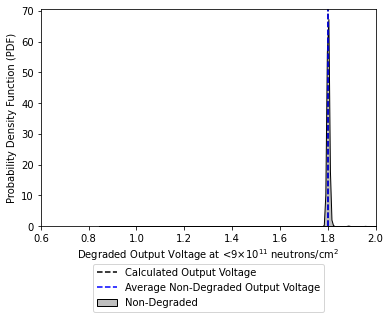

In [123]:
# Creating a KDE plot using the Non-Degraded Output Voltage Data

sns.kdeplot(
    nondegradedOutput,
    label='Non-Degraded',
    color='black',
    fill='True'
)
plt.axvline(1.8, linestyle='--', color='black', label="Calculated Output Voltage")
plt.axvline(np.mean(nondegradedOutput), linestyle='--', color='blue', label="Average Non-Degraded Output Voltage")

plt.legend(fontsize=10, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)

plt.ylabel('Probability Density Function (PDF)')
# plt.ylim([0, 90])
# plt.yticks(np.linspace(0, 1, 11), fontsize=13)
# plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
# plt.tick_params(axis="y",direction="in", pad=10)

# plt.xlabel('Degraded Output Voltage at <100 krad($SiO_{2}$)')
plt.xlabel('Degraded Output Voltage at <$9×10^{11}$ neutrons/cm$^2$')
# plt.xticks(np.arange(0, 8.5, 0.5), fontsize=13)
# plt.tick_params(axis="x",direction="in", pad=10)
plt.xlim([0.6, 2.0])    

In [124]:
print(np.mean(nondegradedOutput))
print(np.mean(degradedOutput1))
print(np.mean(degradedOutput2))
print(np.mean(degradedOutput3))

print(np.std(nondegradedOutput))
print(np.std(degradedOutput1))
print(np.std(degradedOutput2))
print(np.std(degradedOutput3))

1.8003183090306925
1.222723508974487
1.8059375008283514
1.8043488524755766
0.028323944230796858
0.10531325560795277
0.028485572792483347
0.028714266284059552


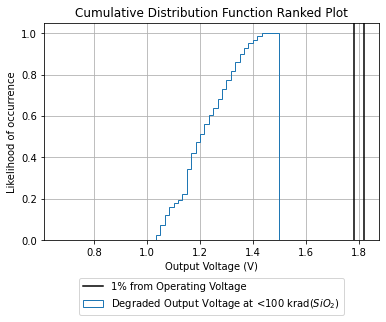

In [125]:
# Quartile Plot for System-Level Analysis - TID
# https://matplotlib.org/stable/gallery/statistics/histogram_cumulative.html

nbins = 50

n, bins, patches = plt.hist(degradedOutput1, 
                           nbins, 
                           density=True, 
                           histtype='step',
                           cumulative=True, 
                           label='Degraded Output Voltage at <100 krad($SiO_{2}$)')

# Showing the 1% Range
plt.axvline(x=1.8*1.01, linestyle='-', color='black', label="1% from Operating Voltage")
plt.axvline(x=1.8*0.99, linestyle='-', color='black')

# Tidying up the figure
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))
plt.title('Cumulative Distribution Function Ranked Plot')
plt.xlabel('Output Voltage (V)')
plt.ylabel('Likelihood of occurrence')

plt.show()

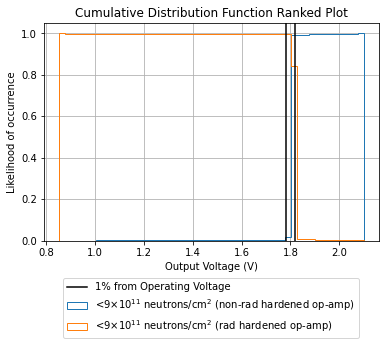

In [126]:
# Quartile Plot for System-Level Analysis - DD (non-rad and rad)
# https://matplotlib.org/stable/gallery/statistics/histogram_cumulative.html

nbins = 50

n, bins, patches = plt.hist(degradedOutput2, 
                           nbins, 
                           density=True, 
                           histtype='step',
                           cumulative=True, 
                           label='<$9×10^{11}$ neutrons/cm$^2$ (non-rad hardened op-amp)')

plt.hist(degradedOutput3, 
        nbins, 
        density=True, 
        histtype='step', 
        cumulative=-1,
        label='<$9×10^{11}$ neutrons/cm$^2$ (rad hardened op-amp)')

# Showing the 1% Range
plt.axvline(x=1.8*1.01, linestyle='-', color='black', label="1% from Operating Voltage")
plt.axvline(x=1.8*0.99, linestyle='-', color='black')

# Tidying up the figure
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))
plt.title('Cumulative Distribution Function Ranked Plot')
plt.xlabel('Output Voltage (V)')
plt.ylabel('Likelihood of occurrence')

plt.show()

In [127]:
print(np.max(degradedOutput1))

1.4992227219887502
